<a href="https://colab.research.google.com/github/JonathanMartignon/ReconocimientoDePatrones/blob/master/Reconocimiento_interno_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving tr_im.nii.gz to tr_im.nii.gz


In [0]:
from google.colab import files
files.upload()

In [0]:
# !gzip -d tr_im.nii.gz
# !gzip -d tr_mask.nii.gz

In [0]:
import nibabel as nib
from matplotlib import pyplot as plt
import numpy as np

In [0]:
# cargamos la imagen
Imagenes = nib.load("./tr_im.nii")
# cargamos la mascara de esa imagen
Mascaras = nib.load("./tr_mask.nii")

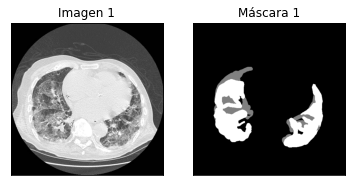

In [5]:
n = 0
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.title("Imagen "+str(n+1))
plt.imshow(Imagenes.get_fdata()[:,:,n].T, cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.title("Máscara "+str(n+1))
plt.imshow(Mascaras.get_fdata()[:,:,n].T, cmap='gray')
plt.xticks([])
plt.yticks([])

plt.show()

# Contamos el número máximo de regiones a identificar

In [0]:
max_uniq = 0
for i in range(Mascaras.shape[2]):
  if len(np.unique(Mascaras.get_fdata()[:,:,i])) > max_uniq:
    max_uniq = len(np.unique(Mascaras.get_fdata()[:,:,i]))

In [7]:
print(f"El número máximo de regiones a idenficar es: {max_uniq}")

El número máximo de regiones a idenficar es: 4


# Juntaremos todos los pixeles acuerdo a su clasificación

In [0]:
Regiones = [[] for i in range (max_uniq)]

#Almacenaremos los pixeles de las 100 imágenes de acuerdo a su clasificación

for i in range(Mascaras.shape[2]):
  img = Imagenes.get_fdata()[:,:,i].reshape(1,-1)
  img = img[0]
  mask = Mascaras.get_fdata()[:,:,i].reshape(1,-1)
  mask = mask[0]

  #Analizamos cada pixel de la imagen
  for j in range(len(img)):
    indice = int(mask[j])
    Regiones[indice].append(img[j])


In [9]:
for i in range(len(Regiones)):
  print(f"La región {i+1} cuenta con {len(Regiones[i])} pixeles")

La región 1 cuenta con 24394464 pixeles
La región 2 cuenta con 1196461 pixeles
La región 3 cuenta con 589210 pixeles
La región 4 cuenta con 34265 pixeles


#Equilibraremos los datos

In [0]:
X = []
Y = []
for i in range(len(Regiones)):
  region = Regiones[i]
  for j in range(34265): # Ajustamos al menor tamaño
    X.append(region[j]) # Almacenamos el pixel
    Y.append(i) # Almacenamos su región
X = np.asarray(X)
Y = np.asarray(Y)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), 
                         Orteg                            Y.reshape(-1,1), 
                                                    test_size=0.30, 
                                                    random_state=6)

# Aplicamos Kmeans

In [0]:
from sklearn.cluster  import KMeans 

In [0]:
k = 4
Kmeans = KMeans(n_clusters= k )

In [158]:
Kmeans.fit(X_train,y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
Y_predict = Kmeans.predict(X_test)

In [0]:
Clasificado_Kmeans = Kmeans.predict(Imagenes.get_fdata()[:,:,1].reshape(-1,1))

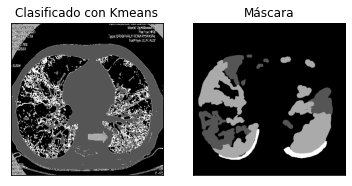

In [161]:
plt.subplot(1,2,1)
plt.title("Clasificado con Kmeans")
plt.imshow(Clasificado_Kmeans.reshape(512,512).T, cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.title("Máscara")
plt.imshow(Mascaras.get_fdata()[:,:,1].T,cmap='gray')
plt.xticks([])
plt.yticks([])

plt.show()

In [0]:
def Obten_mascaras(Imagen ):

  mascaras = [[] for i in range(k)]
  Imagen = Imagen.reshape(1,-1)[0]

  for j in Imagen:
    mascaras[j].append(1)
    for i in range(k):
        if j != i:
          mascaras[i].append(0)

  for i in range(len(mascaras)):
    mascaras[i] = np.asarray(mascaras[i])
    mascaras[i] = mascaras[i].reshape(512,512)
  return mascaras

In [0]:
MSK = Obten_mascaras(Clasificado_Kmeans.reshape(512,512))

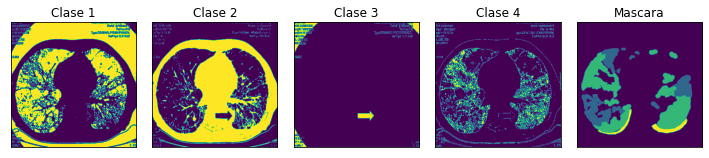

In [168]:
plt.figure(figsize=(10,10))


for i,mascara in enumerate(MSK):
  plt.subplot(5,5,i+1)
  plt.title("Clase "+str(i+1))
  plt.imshow(mascara.T,)
  plt.xticks([])
  plt.yticks([])

plt.subplot(5,5,k+1)
plt.title('Mascara')
plt.imshow(Mascaras.get_fdata()[:,:,1].T)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

### Verificando rendimiento

In [0]:
Catalogo_Kmeans ={3:"Vidrio Esmeralizado", 1:"Consolidación"}

In [0]:
import random as rd

In [0]:
def Funcionamiento(Modelo,regiones,catalogo,shape):
  plt.figure(figsize=shape)

  Imagen = rd.randint(0,Imagenes.shape[2])

  prueba = Imagenes.get_fdata()[:,:,Imagen].T

  prueba = prueba.reshape(-1,1)
  Resultado = Modelo.predict(prueba) 

  MSK = Obten_mascaras(Resultado.reshape(512,512))
  j=0
  for i,mascara in enumerate(MSK):

    if i in regiones:
      j+=1
      plt.subplot(2,len(regiones),j)
      plt.title(catalogo.get(i))
      plt.imshow(mascara)
      plt.xticks([])
      plt.yticks([])

  plt.subplot(2,len(regiones),len(regiones)+2)
  plt.title('Imagen Original')
  plt.imshow(prueba.reshape(512,512),cmap='gray')
  plt.xticks([])
  plt.yticks([])

  plt.tight_layout()
  plt.show()

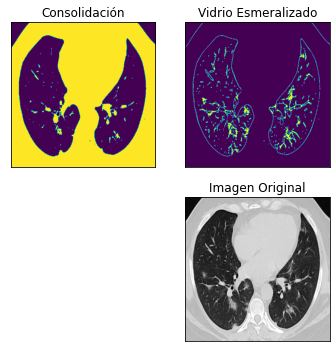

In [243]:
Funcionamiento(Kmeans,[1,3],Catalogo_Kmeans,(5,5))

# KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [188]:
print(f"Contamos con {len(X)} elementos en 'grupos' de {int(len(X)/4)}")

Contamos con 137060 elementos en 'grupos' de 34265


In [0]:
# Creamos el clasificador KNN con 700 vecinos
knn = KNeighborsClassifier(n_neighbors = 700)

In [190]:
Y_pred = knn.fit(X_train,y_train).predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


### Verificamos rendimiento

In [0]:
from sklearn.metrics import classification_report

In [192]:
#KNN
report = classification_report(y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.61      0.73     10258
           1       0.57      0.66      0.61     10266
           2       0.57      0.57      0.57     10297
           3       0.71      0.85      0.77     10297

    accuracy                           0.67     41118
   macro avg       0.69      0.67      0.67     41118
weighted avg       0.69      0.67      0.67     41118



### Verificando su funcionamiento

In [0]:
Catalogo_Knn = {0:"Derrame Pleural", 3:"Consolidación",2:"Vidrio Esmeralizado"}

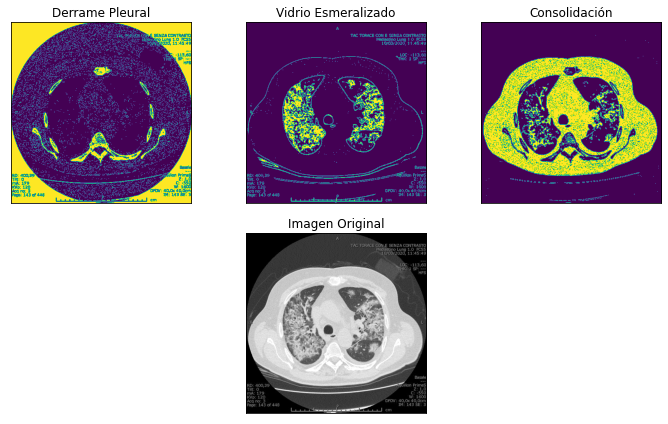

In [247]:
Funcionamiento(knn,[0,3,2],Catalogo_Knn,(10,6))

# Aplicando Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
Bayes = GaussianNB()

In [224]:
Bayes.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
Y_pred = Bayes.predict(X_test)

### Verificamos rendimiento

In [226]:
#Bayes
report = classification_report(y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.55      0.71     10258
           1       0.55      0.75      0.64     10266
           2       0.63      0.38      0.47     10297
           3       0.62      0.92      0.74     10297

    accuracy                           0.65     41118
   macro avg       0.70      0.65      0.64     41118
weighted avg       0.70      0.65      0.64     41118



### Mostramos el funcionamiento

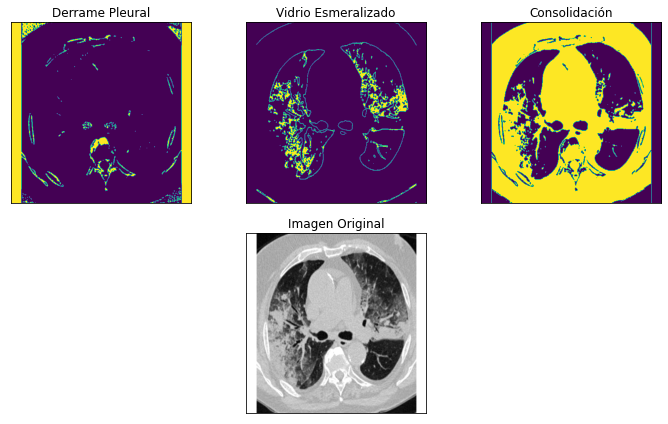

In [234]:
Funcionamiento(Bayes,[0,3,2],Catalogo_Knn,(10,6))

# SVM

In [0]:
from sklearn.svm import SVC

In [0]:
svm = SVC()

In [237]:
svm.fit(X_train,y_train) # tarda un

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
Y_pred = svm.predict(X_test)

### Verificamos el rendimiento

In [239]:
#SVM
Reporte = classification_report(y_test, Y_pred)
print(Reporte)

              precision    recall  f1-score   support

           0       0.97      0.57      0.72     10258
           1       0.58      0.67      0.62     10266
           2       0.59      0.58      0.59     10297
           3       0.69      0.88      0.77     10297

    accuracy                           0.68     41118
   macro avg       0.71      0.68      0.67     41118
weighted avg       0.71      0.68      0.67     41118



### Probamos su funcionamiento

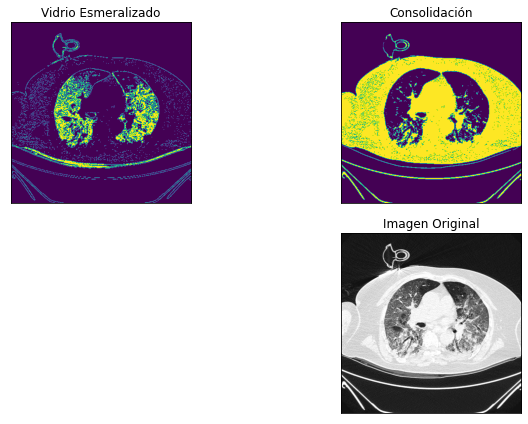

In [245]:
Funcionamiento(svm,[3,2],Catalogo_Knn,(5,5))